# Using Kqlmagic to analyze Azure SQL logs and metrics

## Triangle SQL Server User Group

## 

October 17, 2023

Written by:  Julie Koesmarno

Original Notebook: [Using Kqlmagic to analyze Azure SQL logs and metrics](https:\github.com\MsSQLGirl\jubilant-data-wizards\blob\main\Simple%20Demo\Parameterization\SQLDBLog\AzureSQLLogsAndMetricsWithLogAnalytics.ipynb)

Modifed by: Taiob  Ali

SqlWorldWide.com

There are two main tables in Azure Monitor Logs workspace that capture Azure SQL events:

1. AzureDiagnostics
2. AzureMetric

# 1.  Load Kqlmagic

Need to load Kqlmagic first before we can start connecting to cluster and query data.

In [ ]:
!pip install Kqlmagic --no-cache-dir --upgrade

In [ ]:
%reload_ext Kqlmagic

## 1.1 Connecting to test cluster

In [ ]:
%kql azureDataExplorer://code;cluster='help';database='Samples' //-try-azcli-login-by-profile

## 1.2 Querying the cluster

In [ ]:
%%kql
StormEvents
| where isnotempty(EndLocation) 
| summarize event_count=count() by EndLocation
| order by event_count

In [ ]:
%%kql
StormEvents
| summarize event_count=count(), mid = avg(BeginLat) by State
| sort by mid
| where event_count > 1800
| project State, event_count

### <span style="font-size: 14px;">Query and render columnchart</span>

In [ ]:
%%kql
StormEvents
| summarize count() by State
| sort by count_
| limit 10
| render columnchart title='Top 10 States by Storm Event count'

### <span style="font-size: 14px;">Query and render timechart</span>

In [ ]:
%%kql 
StormEvents
| summarize event_count=count() by bin(StartTime, 1d) 
| render timechart title= 'Daily Storm Events'

<span style="font-size: 14px;">Convert query results to Pandas DataFrame</span>

In [ ]:
%%kql
StormEvents
| summarize max(DamageProperty) by State
| order by max_DamageProperty desc
| take 10

In [ ]:
df = _kql_raw_result_.to_dataframe()
statefilter =df.loc[0].State
statefilter

In [ ]:
%%kql
let _state = statefilter;
StormEvents 
| where State in (_state)
| summarize statecount=count() by bin(StartTime,1d), State
| render timechart title = "Trend"

## 2\. Connect to Log Analytics workspace

Workspace is similar to what a database is to SQL. You connect to Log Analytics workspace to start querying data.

Logging in with non work/school account currently is not working. I have open issue in GitHub.

[Cannot login with personal account (non school or work account) #96](https://github.com/microsoft/jupyter-Kqlmagic/issues/96)

  

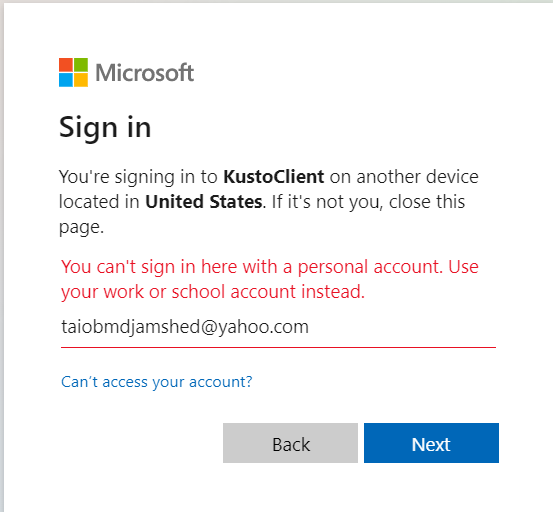

In [ ]:
# Initialize workspace ID to connect to, to analyze Azure SQL log data
workspaceID = '879f44ef-714a-4035-b019-171e748838ad'

In [ ]:
if (workspaceID == ''):
    workspaceID = input("Enter Log Analytics Workspace ID (guid)")
    #print(workspaceID)
    print("workspaceID is set") 

### 2.1 Connect to the desired Log Analytics workspace

Change workspaceID and alias values.

In [ ]:
%kql loganalytics://workspace='workspaceID';alias="trisqlws" -try-azcli-login-by-profile

## 3\. Analyze events by Diagnostic Settings

Let's do a simple query first to analyze the number of events by Operation Name.

> **Note**: Each row in AzureDiagnostic represents an event for specific Operation or category. Some SQL actions may result in generating multiple events of different types.

In [ ]:
%%kql 
AzureDiagnostics
| summarize count() by OperationName


The above query's equivalent in SQL is:
```
SELECT COUNT(*) AS [count_]
FROM AzureDiagnostics
GROUP BY OperationName
```


Count my Azure SQL DB events by category

In [ ]:
%%kql 
AzureDiagnostics
| where LogicalServerName_s == "sqlpassdemoservertaiob"
| where TimeGenerated >= ago(1d)
| summarize count() by Category
| render barchart with (title = "Azure SQL DB Diagnostic Category")

## 4\. Performance troubleshooting Query (from Azure Portal)

Potentially a query or deadlock on the system that could lead to poor performance. The following is a query suggested by Azure Portal.

In [ ]:
%%kql 
AzureMetrics
| where ResourceProvider == "MICROSOFT.SQL"
| where TimeGenerated >=ago(1d)
| where MetricName in ('deadlock')
| parse _ResourceId with * "/microsoft.sql/servers/" Resource // subtract Resource name for _ResourceId
| summarize Deadlock_max_60Mins = max(Maximum) by Resource, MetricName

[Details about this deadlock](#detailsaboutdeadlock)

### AzureMetrics

This is a sample query to dig into AzureMetrics

In [ ]:
%%kql 
AzureMetrics
| project-away TenantId, ResourceId, SubscriptionId, _ResourceId, ResourceGroup // Don't show sensitive columns :) 
| project TimeGenerated, MetricName, Total, Count, UnitName
| take 10


### AzureDiagnostics

This is a sample query to dig into AzureDiagnostics. This table tends to have more details than AzureMetrics.

In [ ]:
%%kql 
AzureDiagnostics
| project-away TenantId, ResourceId, SubscriptionId, ResourceGroup, _ResourceId // Don't show sensitive columns :) 
| take 10

### Analyze (non-audit) Events

In [ ]:
%%kql 
AzureDiagnostics
| summarize event_count=count() by bin(TimeGenerated, 1d), OperationName
| where OperationName <> "AuditEvent"
| render timechart 

### Deadlock Analysis

[]()

In [ ]:
%%kql 
AzureDiagnostics
| where OperationName == "DeadlockEvent"
| project TimeGenerated, Category, Resource, OperationName, Type, deadlock_xml_s
| sort by TimeGenerated desc
| take 50

Find the deadlock query plan

In [ ]:
%%kql 
AzureDiagnostics
| where OperationName == "DeadlockEvent"
| extend d = parse_xml(deadlock_xml_s)
| project TimeGenerated, QuerhPlanHash = d.deadlock.["process-list"].process[0].executionStack.frame[0]["@queryplanhash"], QueryHash = d.deadlock.["process-list"].process[0].executionStack.frame[0]["@queryhash"]
//| sort by TimeGenerated desc
| take 50

### Query Store Runtime Statistics Events

In [ ]:
%%kql 
AzureDiagnostics
| where OperationName == "QueryStoreRuntimeStatisticsEvent"
| project TimeGenerated, query_hash_s, statement_sql_handle_s, query_plan_hash_s
| take 50

### Analyze Errors

In [ ]:
%%kql 
AzureDiagnostics
| where OperationName == "ErrorEvent"
| extend ErrorNumber =  tostring(error_number_d) 
| summarize event_count=count() by EventTime = bin(TimeGenerated, 15m), ErrorNumber
| render timechart 

### Find Deleted table

In [ ]:
%%kql 
AzureDiagnostics
| where action_name_s in ('BATCH COMPLETED')
| project TimeGenerated, Category, action_name_s, statement_s
| where statement_s contains "DROP TABLE"
| sort by TimeGenerated desc 
| take 10

